# Karras pre-conditioning

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [ ]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [ ]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
n_steps = 1000
bs = 512
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)

dl = dls.train
xb,yb = b = next(iter(dl))

In [ ]:
# sig_data = xb.std()
sig_data = 0.66

`y` is clean signal, `n` is `N(0,1)` noise.

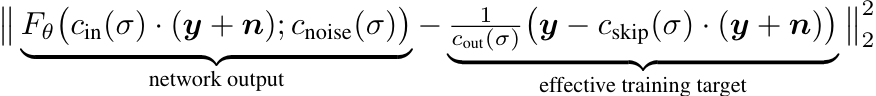

In [ ]:
def scalings(sig):
    totvar = sig**2+sig_data**2
    # c_skip,c_out,c_in
    return sig_data**2/totvar,sig*sig_data/totvar.sqrt(),1/totvar.sqrt()

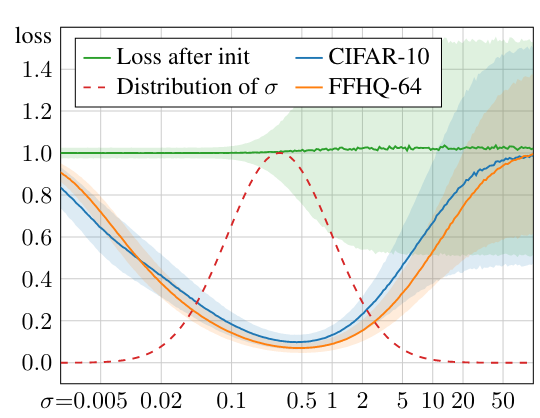

In [ ]:
sig_samp = (torch.randn([10000])*1.2-1.2).exp()

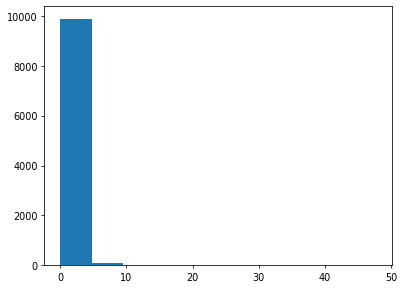

In [ ]:
plt.hist(sig_samp);

In [ ]:
import seaborn as sns

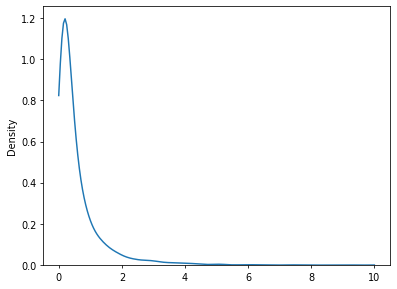

In [ ]:
sns.kdeplot(sig_samp, clip=(0,10));

In [ ]:
def noisify(x0):
    device = x0.device
    sig = (torch.randn([len(x0)])*1.2-1.2).exp().to(x0).reshape(-1,1,1,1)
    noise = torch.randn_like(x0, device=device)
    c_skip,c_out,c_in = scalings(sig)
    noised_input = x0 + noise*sig
    target = (x0-c_skip*noised_input)/c_out
    return (noised_input*c_in,sig.squeeze()),target

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=8)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
dl = dls.train
(noised_input,sig),target = b = next(iter(dl))

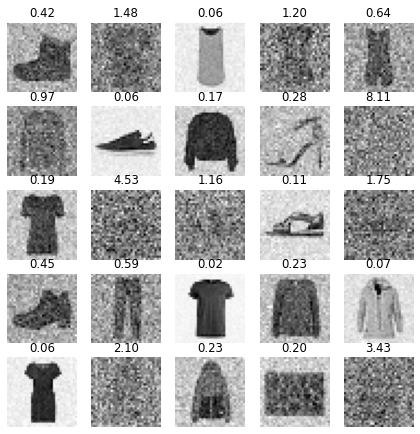

In [ ]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

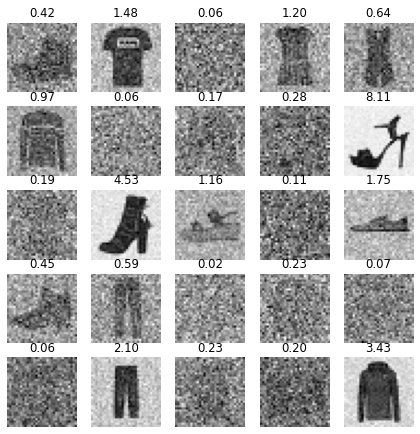

In [ ]:
show_images(target[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

In [ ]:
noised_input.mean(),noised_input.std(),target.mean(),target.std()

(tensor(-0.68160), tensor(1.02096), tensor(-0.40401), tensor(1.03229))

## Train

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [ ]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.703,0,train
0.348,0,eval
0.263,1,train
0.224,1,eval
0.201,2,train
0.197,2,eval
0.188,3,train
0.186,3,eval
0.179,4,train
0.179,4,eval


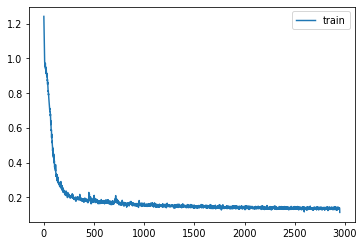

In [ ]:
learn.fit(epochs)

In [ ]:
# torch.save(learn.model, 'models/fashion_karras.pkl')
# model = learn.model = torch.load('models/fashion_karras.pkl').cuda()

In [ ]:
def denoise(target, noised_input): return target*c_out + noised_input*c_skip

In [ ]:
with torch.no_grad():
    sigr = sig.cuda().reshape(-1,1,1,1)
    c_skip,c_out,c_in = scalings(sigr)
    targ_pred = learn.model((noised_input.cuda(),sig.cuda()))
    x0_pred = denoise(targ_pred, noised_input.cuda()/c_in)    

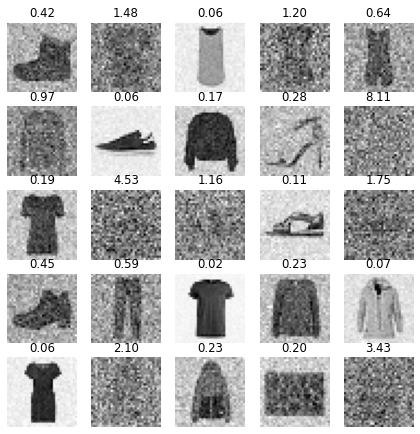

In [ ]:
show_images(noised_input[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

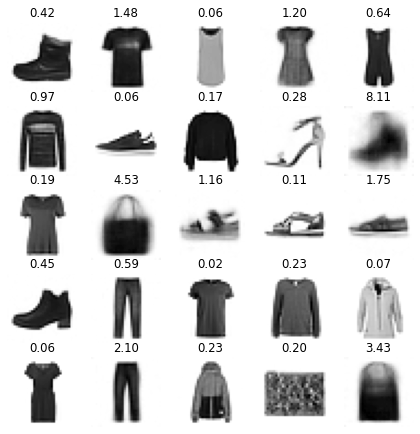

In [ ]:
show_images(x0_pred[:25].clamp(-1,1), imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

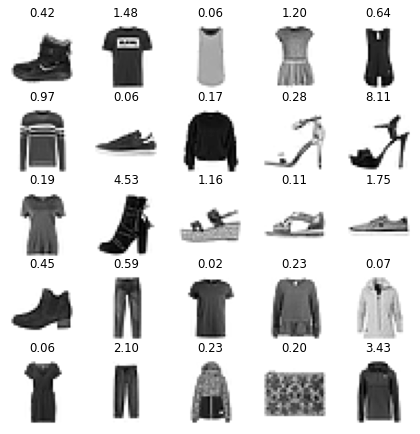

In [ ]:
show_images(denoise(target.cuda(), noised_input.cuda()/c_in)[:25], imsize=1.5, titles=fc.map_ex(sig[:25], '{:.02f}'))

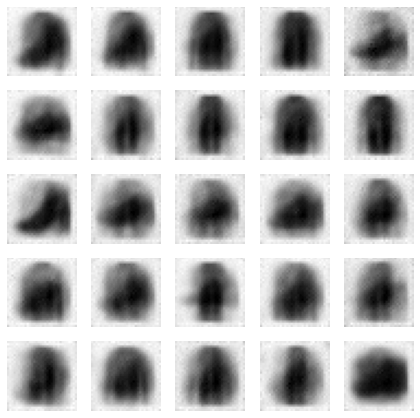

In [ ]:
sig_r = tensor(80.).cuda().reshape(-1,1,1,1)
c_skip,c_out,c_in = scalings(sig_r)
x_r = torch.randn(32,1,32,32).to(model.device)*sig_r
with torch.no_grad():
    targ_pred = learn.model((x_r*c_in,sig_r.squeeze()))
    x0_pred = denoise(targ_pred, x_r)
show_images(x0_pred[:25], imsize=1.5)

In [ ]:
x0_pred.max(),x0_pred.min(),x0_pred.mean(),x0_pred.std()

(tensor(0.63882, device='cuda:0'),
 tensor(-1.18548, device='cuda:0'),
 tensor(-0.54164, device='cuda:0'),
 tensor(0.43493, device='cuda:0'))

## Sampling

In [ ]:
from miniai.fid import ImageEval

In [ ]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [ ]:
sz = (512,1,32,32)

In [ ]:
sz = (2048,1,32,32)

In [ ]:
def sigmas_karras(n, sigma_min=0.01, sigma_max=80., rho=7., device='cpu'):
    ramp = torch.linspace(0, 1, n)
    min_inv_rho = sigma_min**(1/rho)
    max_inv_rho = sigma_max**(1/rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho-max_inv_rho))**rho
    return torch.cat([sigmas, tensor([0.])]).to(device)

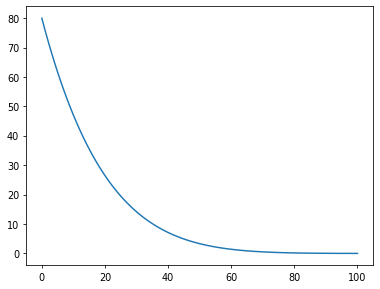

In [ ]:
sk = sigmas_karras(100)
plt.plot(sk);

In [ ]:
def denoise(model, x, sig):
    c_skip,c_out,c_in = scalings(sig)
    return model((x*c_in, sig))*c_out + x*c_skip

In [ ]:
def get_ancestral_step(sigma_from, sigma_to, eta=1.):
    if not eta: return sigma_to, 0.
    var_to,var_from = sigma_to**2,sigma_from**2
    sigma_up = min(sigma_to, eta * (var_to * (var_from-var_to)/var_from)**0.5)
    return (var_to-sigma_up**2)**0.5, sigma_up

In [ ]:
@torch.no_grad()
def sample_euler_ancestral(x, sigs, i, model, eta=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    sigma_down,sigma_up = get_ancestral_step(sig, sig2, eta=eta)
    x = x + (x-denoised)/sig*(sigma_down-sig)
    return x + torch.randn_like(x)*sigma_up

In [ ]:
@torch.no_grad()
def sample_euler(x, sigs, i, model):
    sig,sig2 = sigs[i],sigs[i+1]
    denoised = denoise(model, x, sig)
    return x + (x-denoised)/sig*(sig2-sig)

In [ ]:
@torch.no_grad()
def sample_heun(x, sigs, i, model, s_churn=0., s_tmin=0., s_tmax=float('inf'), s_noise=1.):
    sig,sig2 = sigs[i],sigs[i+1]
    n = len(sigs)
    gamma = min(s_churn/(n-1), 2**0.5-1) if s_tmin<=sig<=s_tmax else 0.
    eps = torch.randn_like(x) * s_noise
    sigma_hat = sig * (gamma+1)
    if gamma > 0: x = x + eps * (sigma_hat**2-sig**2)**0.5
    denoised = denoise(model, x, sig)
    d = (x-denoised)/sig
    dt = sig2-sigma_hat
    x_2 = x + d*dt
    if sig2==0: return x_2
    denoised_2 = denoise(model, x_2, sig2)
    d_2 = (x_2-denoised_2)/sig2
    d_prime = (d+d_2)/2
    return x + d_prime*dt

In [ ]:
def sample(sampler, model, steps=100, sigma_max=80., **kwargs):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    for i in progress_bar(range(len(sigs)-1)):
        x = sampler(x, sigs, i, model, **kwargs)
        preds.append(x)
    return preds

In [ ]:
# preds = sample_lms(model, steps=20, order=3)
# preds = sample(sample_euler_ancestral, model, steps=100, eta=0.5)
preds = sample(sample_euler, model, steps=100)
# preds = sample(sample_heun, model, steps=20, s_churn=0.5)

In [ ]:
s = preds[-1]
s.min(),s.max()

(tensor(-1.08955, device='cuda:0'), tensor(1.46819, device='cuda:0'))

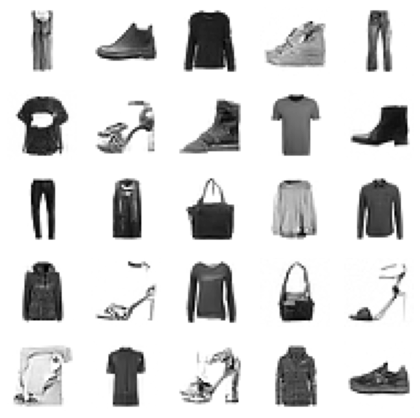

In [ ]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [ ]:
# euler 100
ie.fid(s),ie.kid(s),s.shape

(5.231043207481207, 0.0031656520441174507, torch.Size([2048, 1, 32, 32]))

In [ ]:
# euler 100
ie.fid(s),ie.kid(s),s.shape

(5.406003616592329, 0.015411057509481907, torch.Size([2048, 1, 32, 32]))

In [ ]:
# ancestral 100 0.5
ie.fid(s),ie.kid(s),s.shape

(5.452807558586642, 0.0071729626506567, torch.Size([2048, 1, 32, 32]))

In [ ]:
# heun 50
ie.fid(s),ie.kid(s),s.shape

(6.221842673288506, 0.023713070899248123, torch.Size([2048, 1, 32, 32]))

In [ ]:
# heun 20
ie.fid(s),ie.kid(s),s.shape

(5.610681075267394, -0.005569742992520332, torch.Size([2048, 1, 32, 32]))

In [ ]:
# heun 20, churn 0.5
ie.fid(s),ie.kid(s),s.shape

(5.2517917311790825, 0.026914160698652267, torch.Size([2048, 1, 32, 32]))

In [ ]:
# lms 20
ie.fid(s),ie.kid(s),s.shape

(5.061003587997561, 0.019381564110517502, torch.Size([2048, 1, 32, 32]))

In [ ]:
# reals
ie.fid(xb)

2.5736580178430586

In [ ]:
from scipy import integrate

In [ ]:
def linear_multistep_coeff(order, t, i, j):
    if order-1 > i: raise ValueError(f'Order {order} too high for step {i}')
    def fn(tau):
        prod = 1.
        for k in range(order):
            if j == k: continue
            prod *= (tau-t[i-k]) / (t[i-j]-t[i-k])
        return prod
    return integrate.quad(fn, t[i], t[i+1], epsrel=1e-4)[0]

In [ ]:
@torch.no_grad()
def sample_lms(model, steps=100, order=4, sigma_max=80.):
    preds = []
    x = torch.randn(sz).to(model.device)*sigma_max
    sigs = sigmas_karras(steps, device=model.device, sigma_max=sigma_max)
    ds = []
    for i in progress_bar(range(len(sigs)-1)):
        sig = sigs[i]
        denoised = denoise(model, x, sig)
        d = (x-denoised)/sig
        ds.append(d)
        if len(ds) > order: ds.pop(0)
        cur_order = min(i+1, order)
        coeffs = [linear_multistep_coeff(cur_order, sigs, i, j) for j in range(cur_order)]
        x = x + sum(coeff*d for coeff, d in zip(coeffs, reversed(ds)))
        preds.append(x)
    return preds